# **USER WARNING: RUN THE CODE SLOWLY OR ELSE THE API WILL HAVE SIGNIFICANT TIME OUTS AND WILL TAKE FOREVER TO FINISH. USERS MUST BE PATIENT AND ONCE THE DATA IS EXTRACTED ONCE FROM THE API, IT IS NOT NECESSARY TO RUN IT MULTIPLE TIMES.

In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup, Comment
!pip install nba_api

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# **Data Collection**

This section accesses the data for 10 selected players for analysis

## Extract Player ID

In [ ]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import playerestimatedmetrics
# List of player names
player_names = [
    "Alex Caruso",
    "Josh Hart",
    "Austin Reaves",
    "Tyus Jones",
    "Derrick White",
    "Malcolm Brogdon",
    "Donte DiVincenzo",
    "Fred VanVleet",
    "T.J. McConnell",
    "Duncan Robinson",
    ]

# List to store player IDs
player_ids = []

for name in player_names:
    player_info = players.find_players_by_full_name(name)
    if player_info:
        player_ids.append(player_info[0]['id'])  # Add the ID to the list

#what this program does is go through the nba api and select players based on
#and extracts their player id. These ids are used later to find stats
print(player_ids)


[1627936, 1628404, 1630559, 1626145, 1628401, 1627763, 1628978, 1627832, 204456, 1629130]


## List of Seasons

In [ ]:
season_list = ['2021-22','2022-23','2023-24','2024-25','2025-26']
season_list
#this season list is used to anlayze the past 5 years of play
#the reason i did this is two-fold, a) anything more results in time-outs in the api
#b) this allows us to predict trends in finding the best value recently

['2021-22', '2022-23', '2023-24', '2024-25', '2025-26']

## Function for Advanced Statistics from the Last 5 Seasons (Uses List of Seasons)

In [ ]:
def get_last5_advanced_stats(player_id_unique, season_list_):
  last5_seasons = [] #creates empty list for dataframes for each season
  for season1 in season_list_: #for every season in list (past 5 years), perform this function
    advanced = playerestimatedmetrics.PlayerEstimatedMetrics(
    season=season1,
    season_type="Regular Season")
    #extract the advanced metrics
    adv_df = advanced.get_data_frames()[0]#extract the dataframe and add it to the list
    adv_df = adv_df[adv_df["PLAYER_ID"] == player_id_unique]
    last5_seasons.append(adv_df)
  #combine all the smaller dfs into one df of all seasons
  combined_df = pd.concat(last5_seasons, ignore_index=True)
  return combined_df

#this function has to be called independently, otherwise, the api times out on the user and the program can't be run.

## Features

In [ ]:
features = [
    "E_OFF_RATING", "E_DEF_RATING",
    "E_AST_RATIO", "E_OREB_PCT","E_DREB_PCT",
    "E_TOV_PCT", "E_USG_PCT", "E_PACE"
]
#these will be the features used for analysis, most other metrics are rankings of these stats

## Data for Each Player

In [ ]:
ac_data = get_last5_advanced_stats(1627936, season_list)
ac_df_lag = ac_data[features + ["E_NET_RATING"]].shift(-1)
#gets the data for alex caruso and shift the next year NRTG to the base year data

In [ ]:
jh_data = get_last5_advanced_stats(1628404, season_list)
jh_df_lag = jh_data[features + ["E_NET_RATING"]].shift(-1)
#gets the data for Josh Hart and shift the next year NRTG to the base year data

In [ ]:
ar_data = get_last5_advanced_stats(1630559, season_list)
ar_df_lag = ar_data[features + ["E_NET_RATING"]].shift(-1)
#gets the data for Austin Reaves and shift the next year NRTG to the base year data

In [ ]:
tj_data = get_last5_advanced_stats(1626145, season_list)
tj_df_lag = tj_data[features + ["E_NET_RATING"]].shift(-1)
#gets the data for Tyus Jones and shift the next year NRTG to the base year data

In [ ]:
dw_data = get_last5_advanced_stats(1628401, season_list)
dw_df_lag = dw_data[features + ["E_NET_RATING"]].shift(-1)
#gets the data for Derrick White and shift the next year NRTG to the base year data

In [ ]:
mb_data = get_last5_advanced_stats(1627763, season_list)
mb_df_lag = mb_data[features + ["E_NET_RATING"]].shift(-1)
#gets the data for Malcolm Brogdon and shift the next year NRTG to the base year data

In [ ]:
dd_data = get_last5_advanced_stats(1628978, season_list)
dd_df_lag = dd_data[features + ["E_NET_RATING"]].shift(-1)
#gets the data for Donte DiVencenzo and shift the next year NRTG to the base year data

In [ ]:
fv_data = get_last5_advanced_stats(1627832, season_list)
fv_df_lag = fv_data[features + ["E_NET_RATING"]].shift(-1)
#gets the data for Fred VanVleet and shift the next year NRTG to the base year data

In [ ]:
tm_data = get_last5_advanced_stats(1629130, season_list)
tm_df_lag = tm_data[features + ["E_NET_RATING"]].shift(-1)
#gets the data for T.J McConnell and shift the next year NRTG to the base year data

In [ ]:
dr_data = get_last5_advanced_stats(204456, season_list)
dr_df_lag = dr_data[features + ["E_NET_RATING"]].shift(-1)
#gets the data for Duncan Robinson and shift the next year NRTG to the base year data

## Data Integration

In [ ]:
testing_df = pd.concat([ac_df_lag, jh_df_lag, ar_df_lag, tj_df_lag, dw_df_lag, mb_df_lag, dd_df_lag, fv_df_lag, tm_df_lag, dr_df_lag], ignore_index=True)
testing_df = testing_df.dropna()
#This combines all the dataframes and make it fully based on the data without the names

In [ ]:
target_col = 'E_NET_RATING'
#NET_RATING is the metric of player impact
feature_cols = [col for col in testing_df.columns if col != target_col]
#all features in the dfs that aren't E-Rating are features
X = testing_df[feature_cols] # Corrected to use testing_df
y = testing_df[target_col]   # Corrected to use testing_df

# **MODEL CONSTRUCTION: Linear, GBR, and ANN**

This section assembles all three models of linear regression, GBR regression, and ANN and compares the model on the dataset to one another using R^2 and RMSE.



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Baseline and helper function

In [ ]:
#model comparison with linear,
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
import torch.optim as optim


# helper function to evaluate regression models
# prints RMSE (how far off predictions are) and R^2 (how much variance is explained)
def eval_regression(name, y_true, y_pred):
    # computation for rmse and r-squared score
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} -> RMSE: {rmse:.3f} | R^2: {r2:.3f}")

# baseline, always predict the average net rating
# this gives us a gauge of a benchmark to make sure our model is actually improving the prediction accuracy
y_pred_mean = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)
eval_regression("Baseline (Predict Mean)", y_test, y_pred_mean)

Baseline (Predict Mean) -> RMSE: 6.785 | R^2: -0.152


## Linear Regression Model

In [ ]:
# linear regression model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# predict and evaluate the linear regression model
y_pred_lin = lin_model.predict(X_test)
eval_regression("Linear Regression", y_test, y_pred_lin)


Linear Regression -> RMSE: 0.042 | R^2: 1.000


## Gradient Booster Model

In [ ]:
# gradient booster model
# initialize gradient boosting regressor
# uses many small decision trees to capture non-linear relationships
gb_model = GradientBoostingRegressor(
    n_estimators=300, learning_rate=0.1, max_depth=3, random_state=42
)
gb_model.fit(X_train, y_train)

# evaluate
y_pred_gb = gb_model.predict(X_test)
eval_regression("Gradient Boosting", y_test, y_pred_gb)

Gradient Boosting -> RMSE: 3.206 | R^2: 0.743


## Pytorch Neural Net Model

In [ ]:
# pytorch neural net model
# standardize features using train stats only
X_train_np = X_train.values.astype(np.float32)
X_test_np  = X_test.values.astype(np.float32)

# this prevents information leakage from the test set
mu = X_train_np.mean(axis=0)
sigma = X_train_np.std(axis=0) + 1e-8

# standardize features (zero mean, unit variance)
X_train_sc = (X_train_np - mu) / sigma
X_test_sc  = (X_test_np - mu) / sigma

y_train_np = y_train.values.astype(np.float32).reshape(-1, 1)
y_test_np  = y_test.values.astype(np.float32).reshape(-1, 1)

X_train_t = torch.tensor(X_train_sc, dtype=torch.float32)
X_test_t  = torch.tensor(X_test_sc, dtype=torch.float32)
y_train_t = torch.tensor(y_train_np, dtype=torch.float32)
y_test_t  = torch.tensor(y_test_np, dtype=torch.float32)

# neural network model
input_dim = X_train_t.shape[1]

# simple feedforward neural network
nn_model = nn.Sequential(
    nn.Linear(input_dim, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)

# define loss function
loss_fn = nn.MSELoss()
# define optimizer
optimizer = optim.Adam(nn_model.parameters(), lr=0.01)

# training loop
losses = []
# train the model for 300 epochs
for epoch in range(300):
    # forward pass, generate predictions
    yhat = nn_model(X_train_t)
    # calculate loss between predictions and true values
    loss = loss_fn(yhat, y_train_t)
    # reset gradients from previous iteration
    optimizer.zero_grad()
    # backpropagation, compute gradients
    loss.backward()
    optimizer.step()

    losses.append(loss.item())


# switch model to evaluation mode
nn_model.eval()
# disable gradient tracking for inference
with torch.no_grad():
    y_pred_nn = nn_model(X_test_t).numpy().reshape(-1)

# evaluate neural network performance
eval_regression("Neural Net (PyTorch)", y_test.values, y_pred_nn)


Neural Net (PyTorch) -> RMSE: 1.764 | R^2: 0.922


## Feature Importance for GBR

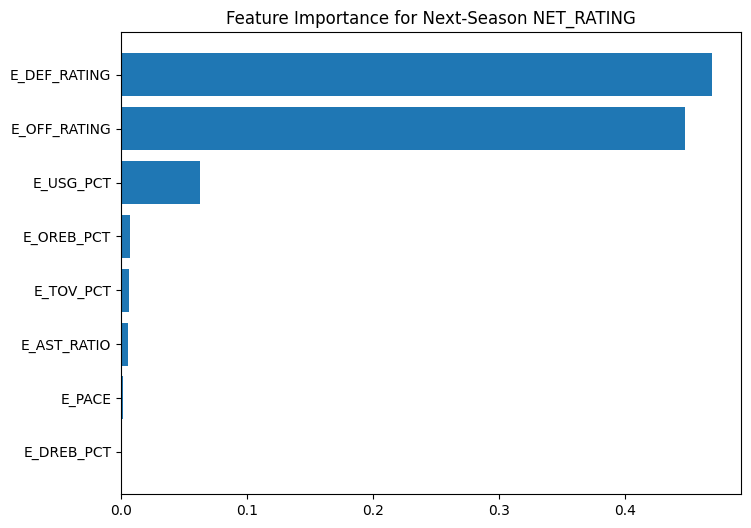

In [ ]:
# extract feature importance scores from the trained gradient boosting model
# these values tell us how much each feature contributed to predictions
importances = gb_model.feature_importances_

# get the indices that would sort the features from least important to most important
sorted_idx = np.argsort(importances)

plt.figure(figsize=(8,6))

# plot a horizontal bar chart of feature importance
# features with larger bars had more influence on the model's predictions
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_cols[i] for i in sorted_idx])
plt.title("Feature Importance for Next-Season NET_RATING")
plt.show()
#displays what features are important


# **TESTING ON NEW PLAYERS**

the following sets of data and scoring is applied to other players of different archetypes

## NEW TEST PLAYER DATA COLLECTION


In [ ]:
db_test_data = get_last5_advanced_stats(players.find_players_by_full_name('Desmond Bane')[0]['id'],season_list)[features + ["E_NET_RATING"]].shift(-1)
db_test_data = db_test_data.dropna()

In [ ]:
LD_test_data = get_last5_advanced_stats(players.find_players_by_full_name('Luka Doncic')[0]['id'],season_list)[features + ["E_NET_RATING"]].shift(-1)
LD_test_data = LD_test_data.dropna()

In [ ]:
DM_test_data = get_last5_advanced_stats(players.find_players_by_full_name('Donovan Mitchell')[0]['id'],season_list)[features + ["E_NET_RATING"]].shift(-1)
DM_test_data = DM_test_data.dropna()

In [ ]:
tyrese_test_data = get_last5_advanced_stats(players.find_players_by_full_name('Tyrese Maxey')[0]['id'],season_list)[features + ["E_NET_RATING"]].shift(-1)
tyrese_test_data = tyrese_test_data.dropna()

In [ ]:
jalenb_test_data = get_last5_advanced_stats(players.find_players_by_full_name('Jalen Brunson')[0]['id'],season_list)[features + ["E_NET_RATING"]].shift(-1)
jalenb_test_data = jalenb_test_data.dropna()

In [ ]:
OGA_test_data = get_last5_advanced_stats(players.find_players_by_full_name('OG Anunoby')[0]['id'],season_list)[features + ["E_NET_RATING"]].shift(-1)
OGA_test_data = OGA_test_data.dropna()

In [ ]:
MarcusS_test_data = get_last5_advanced_stats(players.find_players_by_full_name('Marcus Smart')[0]['id'],season_list)[features + ["E_NET_RATING"]].shift(-1)
MarcusS_test_data = MarcusS_test_data.dropna()

## Evalauting players based on all models in this order (ANN, GBR, and Linear)

## Neural Net

In [ ]:
# Helper function to evaluate a player with the Neural Net
def eval_nn_player(player_name, player_df, nn_model, mu, sigma, target_col, feature_cols):
    X_player_np = player_df[feature_cols].values.astype(np.float32)
    y_player_np = player_df[target_col].values.astype(np.float32)

    X_player_sc = (X_player_np - mu) / sigma
    X_player_t = torch.tensor(X_player_sc, dtype=torch.float32)

    nn_model.eval()
    with torch.no_grad():
        y_pred_nn_player = nn_model(X_player_t).numpy().reshape(-1)

    eval_regression(f"Neural Net ({player_name})", y_player_np, y_pred_nn_player)

# Evaluate Desmond Bane
eval_nn_player("Desmond Bane", db_test_data, nn_model, mu, sigma, target_col, feature_cols)
# Evaluate Luka Doncic
eval_nn_player("Luka Doncic", LD_test_data, nn_model, mu, sigma, target_col, feature_cols)
# Evaluate Donovan Mitchell
eval_nn_player("Donovan Mitchell", DM_test_data, nn_model, mu, sigma, target_col, feature_cols)
# Evaluate Tyrese Maxey
eval_nn_player("Tyrese Maxey", tyrese_test_data, nn_model, mu, sigma, target_col, feature_cols)
# Evaluate Jalen Brunson
eval_nn_player("Jalen Brunson", jalenb_test_data, nn_model, mu, sigma, target_col, feature_cols)
# Evaluate OG Anunoby
eval_nn_player("OG Anunoby", OGA_test_data, nn_model, mu, sigma, target_col, feature_cols)
# Evaluate Marcus Smart
eval_nn_player("Marcus Smart", MarcusS_test_data, nn_model, mu, sigma, target_col, feature_cols)

Neural Net (Desmond Bane) -> RMSE: 1.426 | R^2: 0.945
Neural Net (Luka Doncic) -> RMSE: 0.965 | R^2: 0.856
Neural Net (Donovan Mitchell) -> RMSE: 0.437 | R^2: 0.967
Neural Net (Tyrese Maxey) -> RMSE: 1.731 | R^2: 0.759
Neural Net (Jalen Brunson) -> RMSE: 1.348 | R^2: 0.907
Neural Net (OG Anunoby) -> RMSE: 0.869 | R^2: 0.979
Neural Net (Marcus Smart) -> RMSE: 0.979 | R^2: 0.873


## Gradient Boosting

In [ ]:
#Gradient Evaluation of new players
# Evaluate Desmond Bane
print("Gradient Boosting (Desmond Bane) --> R^2: " + str(gb_model.score(db_test_data[feature_cols], db_test_data[target_col])))
# Evaluate Luka Doncic
print("Gradient Boosting (Luka Doncic) --> R^2: " + str(gb_model.score(LD_test_data[feature_cols], LD_test_data[target_col])))
# Evaluate Donovan Mitchell
print("Gradient Boosting (Donovan Mitchell) --> R^2: " + str(gb_model.score(DM_test_data[feature_cols], DM_test_data[target_col])))
# Evaluate Tyrese Maxey
print("Gradient Boosting (Tyrese Maxey) --> R^2: " + str(gb_model.score(tyrese_test_data[feature_cols], tyrese_test_data[target_col])))
# Evaluate Jalen Brunson
print("Gradient Boosting (Jalen Brunson) --> R^2: " + str(gb_model.score(jalenb_test_data[feature_cols], jalenb_test_data[target_col])))
# Evaluate OG Anunoby
print("Gradient Boosting (OG Anunoby) --> R^2: " + str(gb_model.score(OGA_test_data[feature_cols], OGA_test_data[target_col])))
# Evaluate Marcus Smart
print("Gradient Boosting (Marcus Smart) --> R^2: " + str(gb_model.score(MarcusS_test_data[feature_cols], MarcusS_test_data[target_col])))

Gradient Boosting (Desmond Bane) --> R^2: 0.9743967655000101
Gradient Boosting (Luka Doncic) --> R^2: 0.8582647976527114
Gradient Boosting (Donovan Mitchell) --> R^2: 0.7384326696066289
Gradient Boosting (Tyrese Maxey) --> R^2: 0.8721854860729408
Gradient Boosting (Jalen Brunson) --> R^2: 0.6905770189373754
Gradient Boosting (OG Anunoby) --> R^2: 0.9327896121603556
Gradient Boosting (Marcus Smart) --> R^2: 0.933681374889538


## Linear Regression

In [ ]:
#linear eval

# Evaluate Desmond Bane
print("Linear Regression (Desmond Bane) --> R^2: " + str(lin_model.score(db_test_data[feature_cols], db_test_data[target_col])))
# Evaluate Luka Doncic
print("Linear Regression (Luka Doncic) --> R^2: " + str(lin_model.score(LD_test_data[feature_cols], LD_test_data[target_col])))
# Evaluate Donovan Mitchell
print("Linear Regression (Donovan Mitchell) --> R^2: " + str(lin_model.score(DM_test_data[feature_cols], DM_test_data[target_col])))
# Evaluate Tyrese Maxey
print("Linear Regression (Tyrese Maxey) --> R^2: " + str(lin_model.score(tyrese_test_data[feature_cols], tyrese_test_data[target_col])))
# Evaluate Jalen Brunson
print("Linear Regression (Jalen Brunson) --> R^2: " + str(lin_model.score(jalenb_test_data[feature_cols], jalenb_test_data[target_col])))
# Evaluate OG Anunoby
print("Linear Regression (OG Anunoby) --> R^2: " + str(lin_model.score(OGA_test_data[feature_cols], OGA_test_data[target_col])))
# Evaluate Marcus Smart
print("Linear Regression (Marcus Smart) --> R^2: " + str(lin_model.score(MarcusS_test_data[feature_cols], MarcusS_test_data[target_col])))

Linear Regression (Desmond Bane) --> R^2: 0.9997285571569571
Linear Regression (Luka Doncic) --> R^2: 0.9989339302642694
Linear Regression (Donovan Mitchell) --> R^2: 0.9993138866986978
Linear Regression (Tyrese Maxey) --> R^2: 0.9996453333177334
Linear Regression (Jalen Brunson) --> R^2: 0.9998373251805794
Linear Regression (OG Anunoby) --> R^2: 0.99947571049149
Linear Regression (Marcus Smart) --> R^2: 0.9998214370098899
